In [1]:
import json
import re
from pymongo import MongoClient
import numpy as np
import matplotlib.pyplot as plt

In [2]:
client = MongoClient('mongodb://localhost:27017/')
db = client['sd_business']
businesses_colleciton = db['business']
housing_collection = db['apartment']
bus_collection = db['bus_stops']


In [3]:
# Perform the aggregation pipeline
pipeline = [
    {"$group": {"_id": None, "prices": {"$push": "$price"}}},
    {"$project": {"_id": 0, "prices": 1}},
    {"$unwind": "$prices"},
    {"$group": {"_id": "$prices", "count": {"$sum": 1}}},
    {"$sort": {"_id": 1}}
]

result = list(housing_collection.aggregate(pipeline))

prices = [item['_id'] for item in result if item['_id'] is not None]
prices = [
    int(re.match(r"\$(\d[\d,]*)", price).group(1).replace(',', '')) 
    if isinstance(price, str) else int(price) for price in prices
]

In [4]:
prices = np.array(prices)
mean = np.mean(prices)
median = np.median(prices)
std = np.std(prices)
first_quartile = np.percentile(prices, 25)
third_quartile = np.percentile(prices, 75)
iqr = third_quartile - first_quartile
low_threshold = first_quartile - 1.5 * iqr
high_threshold = third_quartile + 1.5 * iqr
trimmed_prices = prices[(prices > low_threshold) & (prices < high_threshold)]

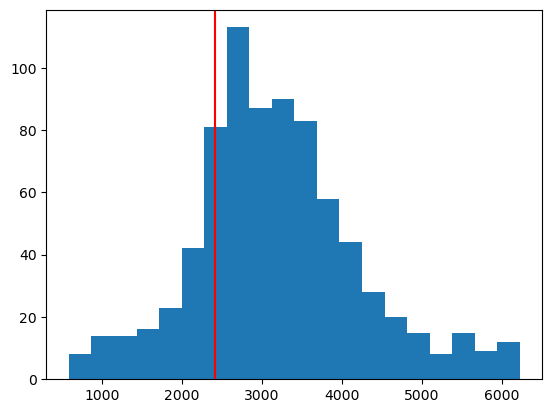

In [5]:
plt.hist(trimmed_prices, bins=20)
plt.axvline(trimmed_prices[np.random.randint(0, len(trimmed_prices))], color='red', label='Mean')

In [34]:
# Find listing that has a price between 2400 - 4000 a month, In-Unit Washer Dryer and Allows pet

pipeline = [
    {"$match": {
        "price": {"$gte": 2400, "$lte": 4000},
        "sqft": {"$gte": 850},
        "$or": [
            {"amenities": {"$regex": ".*In-Unit Washer & Dryer.*"}},
            {'laundry': {'$regex': '.*w/d in unit*'}}
        ],
        "$or": [
            {'pets': {'$regex': '.*cats*'}},
            {'Pet Policy': {'$regex': '.*Cats Allowed*'}}
        ]
    }},
]

filtered_res = housing_collection.aggregate(pipeline)

lats, longs = [], []
for res in filtered_res:
    print(res)
    if 'lat' not in res.keys() or 'lon' not in res.keys():
        continue
    if res['lat'] is None or res['lon'] is None:
        continue
    lats.append(res['lat'])
    longs.append(res['lon'])

{'_id': ObjectId('648baffa41b4b5c44bc0b4b1'), 'post_id': 7442193829, 'beds': 3, 'baths': 2.0, 'price': 3587, 'sqft': 1050, 'houseType': 'apartment', 'rentPeriod': None, 'parking': 'off-street parking', 'laundry': 'w/d in unit', 'pets': 'cats are OK - purrr', 'smoking': None, 'air conditioning': None, 'wheelchair accessible': None, 'EV charging': None, 'furnished': None, 'lat': 32.7545541394, 'lon': -117.2192298552}
{'_id': ObjectId('648baffa41b4b5c44bc0b4b3'), 'post_id': 7443784985, 'beds': 1, 'baths': 1.0, 'price': 2550, 'sqft': 900, 'houseType': 'apartment', 'rentPeriod': None, 'parking': 'off-street parking', 'laundry': 'laundry in bldg', 'pets': 'cats are OK - purrr', 'smoking': 'no smoking', 'air conditioning': None, 'wheelchair accessible': None, 'EV charging': None, 'furnished': None, 'lat': 32.749209, 'lon': -117.247924}
{'_id': ObjectId('648baffa41b4b5c44bc0b4c9'), 'post_id': 7447332443, 'beds': 2, 'baths': 2.0, 'price': 2480, 'sqft': 954, 'houseType': 'apartment', 'rentPeriod

In [36]:
len(lats), len(longs)

(113, 113)

In [37]:
with open('sample_houses.txt', 'w') as f:
    for lat, lon in zip(lats, longs):
        f.write(f'{lat},{lon}\n')